In [1]:
import sys
import numpy as np
sys.path.insert(1,'../')
from aqsc import *
import time
import os

import jax.numpy as jnp
from functools import partial
from jax import jit, vmap, tree_util

# Testing special cases (Works!)

In [12]:
a = jnp.array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
    [4,5,6],
    [1,2,3],
])

a2 = jnp.array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
    [4,5,6],
])

b = jnp.array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

b2 = jnp.array([
    [1,2,3],
    [4,5,6],
])

c = jnp.array([
    [10],
    [20],
    [30],
])

r = jnp.array([
    [10,100,1000],
])

g = jnp.array([
    [10,100,1000,10000],
])

test_even_a = ChiPhiFunc(a, 4)
test_odd_a = ChiPhiFunc(a2, 4)
test_even_b = ChiPhiFunc(b, 4)
test_odd_b = ChiPhiFunc(b2, 4)
single_col = ChiPhiFunc(c, 4)
single_row = ChiPhiFunc(r, 4)
wrong_grid = ChiPhiFunc(g, 4)
test_odd_a_wrong_nfp = ChiPhiFunc(a, 2)
test_even_a_wrong_nfp = ChiPhiFunc(a2, 2)
zero = ChiPhiFuncSpecial(0)
null_a = ChiPhiFuncSpecial(-2)
null_b = ChiPhiFuncSpecial(-3)
print('even+even:', not (test_even_a+test_even_b).is_special())
print('odd+odd:', not (test_odd_a+test_odd_b).is_special())
print('even+const', not (test_even_a+1).is_special())
print('even+row', not (test_even_a+single_row).is_special())
print('even+odd = error -4:', (test_odd_a+test_even_b).nfp==-4)
print('zero+odd = odd', jnp.all((test_odd_a+zero).content ==test_odd_a.content))
print('zero+even = even', jnp.all((test_even_a+zero).content ==test_even_a.content))
print('odd+row = error -4:', (test_odd_a+single_row).nfp==-4)
print('ChiPhiFunc(*, <= 0, False) = error -2:', jnp.isnan(ChiPhiFunc(a, -1).content))
print('zero+const = const', (6+zero)==6)
print('zero+zero = zero', (zero+zero).nfp==0)
print('zero+error = error', (zero+null_a).nfp==-2)
print('error+zero = error', (null_a+zero).nfp==-2)
print('error a+error b = error ab', (null_a+null_b).nfp==-203)
print('Testing products -----')
print('even*even:', (test_even_a*test_even_b).content.shape[0]==7)
print('even*const', (test_even_a*2).content.shape[0]==5)
print('zero*const', (test_even_a*zero).nfp==0)
print('zero*even = zero', (test_even_a*zero).nfp==0)
print('even*zero = zero', (zero*test_even_a).nfp==0)
print('zero*zero = zero', (zero*zero).nfp==0)
print('zero*error = error', (zero*null_a).nfp==-2)
print('error*zero = error', (null_a*zero).nfp==-2)
print('error a*error b = error ab', (null_a*null_b).nfp==-203)
print('Testing division -----')
print('even/even:', (test_even_a/test_even_b).is_special())
print('even/const', (test_even_a/2).content.shape[0]==5)
print('const/even:', (2/test_even_b).is_special())
print('even/row:', not (test_even_a/single_row).is_special())
print('const/row:', not (2/single_row).is_special())
print('const/zero:', (2/zero).nfp==-8)
print('zero/const:', (zero/2).nfp==0)
print('even/zero:', (test_even_a/zero).nfp==-8)
print('zero/even:', (zero/test_even_a).nfp==0)
print('error a/error b = error ab', (null_a/null_b).nfp==-203)

even+even: True
odd+odd: True
even+const True
even+row True
even+odd = error -4: True
zero+odd = odd True
zero+even = even True
odd+row = error -4: True
ChiPhiFunc(*, <= 0, False) = error -2: True
zero+const = const True
zero+zero = zero True
zero+error = error True
error+zero = error True
error a+error b = error ab True
Testing products -----
even*even: True
even*const True
zero*const True
zero*even = zero True
even*zero = zero True
zero*zero = zero True
zero*error = error True
error*zero = error True
error a*error b = error ab True
Testing division -----
even/even: True
even/const True
const/even: True
even/row: True
const/row: True
const/zero: True
zero/const: True
even/zero: True
zero/even: True
error a/error b = error ab True


# Testing display_content() (Works!)

In [3]:
content_single_nfp = np.array([
    jnp.sin(4*points), # sin component
    jnp.cos(4*points) # cos component
])
content1 = np.array([
    jnp.sin(points), # sin component
    jnp.cos(points) # cos component
])
single_period = ChiPhiFunc(content_single_nfp, 1, trig_mode=True)
four_period = ChiPhiFunc(content1, nfp=4, trig_mode=True)


A


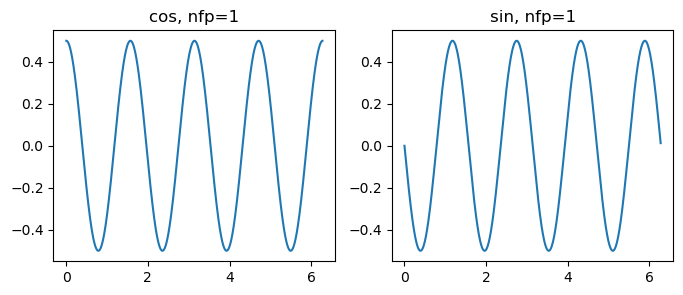

B


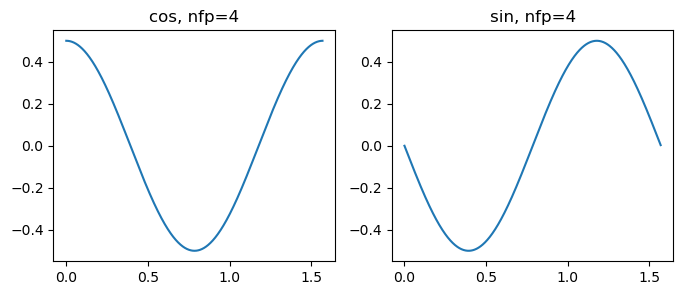

One of A and B is converted to have nfp=1.
A.nfp = 1
B.nfp = 4
A


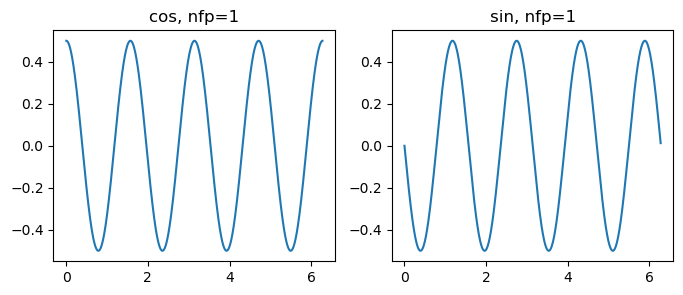

B


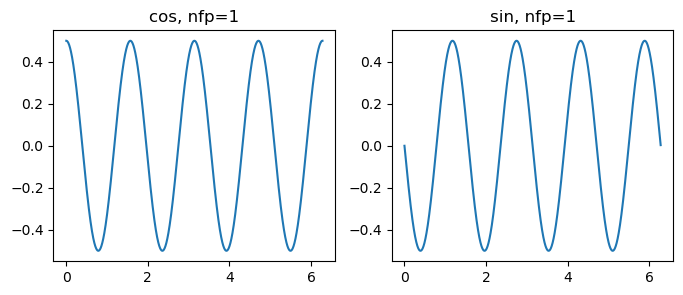

Phi grid number not matched.


()

In [4]:
compare_chiphifunc(single_period, four_period, simple_mode=False, trig_mode=True)

# Defining test variables

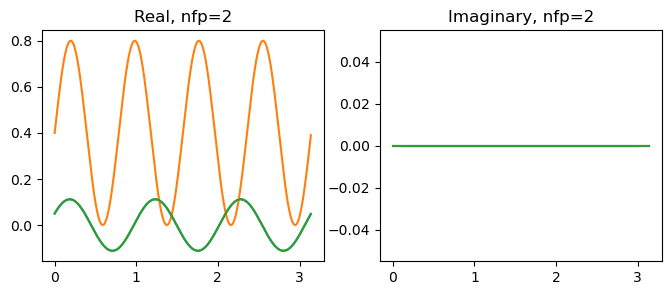

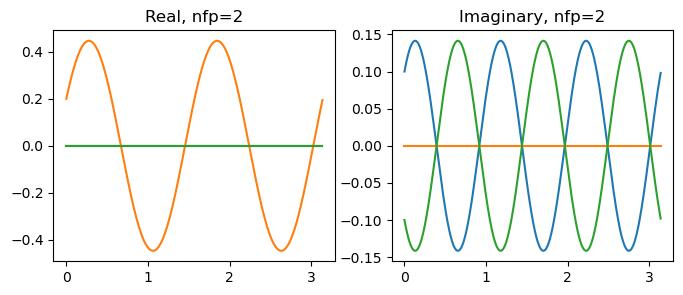

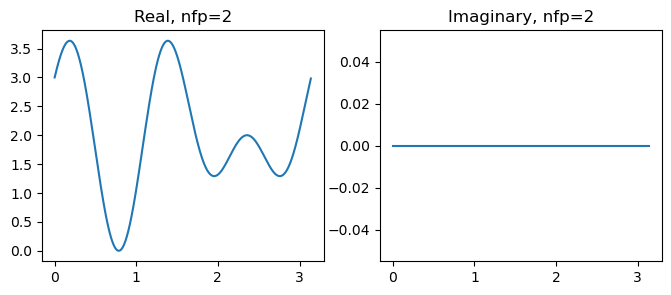

In [5]:
# Generating 2 random test cases and answers
nfp = np.random.randint(4)+2

# Creating 2 random ChiPhiFunc's for testing
rands1 = np.random.randint(5, size=12)
func1 = np.vectorize(lambda chi, phi : \
    (rands1[0]/10*np.sin(rands1[1]*nfp*phi) + rands1[2]/10*np.cos(rands1[3]*nfp*phi))*np.sin(2*chi)+\
    rands1[4]/10*np.sin(rands1[5]*nfp*phi) + rands1[6]/10*np.cos(rands1[7]*nfp*phi)+\
    (rands1[8]/10*np.sin(rands1[9]*nfp*phi) + rands1[10]/10*np.cos(rands1[11]*nfp*phi))*np.cos(2*chi))

content1 = np.array([
    rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points)
])


rands2 = np.random.randint(5, size=12)
func2 = np.vectorize(lambda chi, phi : \
    (rands2[0]/10*np.sin(rands2[1]*nfp*phi) + rands2[2]/10*np.cos(rands2[3]*nfp*phi))*np.sin(2*chi)+\
    rands2[4]/10*np.sin(rands2[5]*nfp*phi) + rands2[6]/10*np.cos(rands2[7]*nfp*phi)+\
    (rands2[8]/10*np.sin(rands2[9]*nfp*phi) + rands2[10]/10*np.cos(rands2[11]*nfp*phi))*np.cos(2*chi))
content2 = np.array([
    rands2[0]/10*np.sin(rands2[1]*points) + rands2[2]/10*np.cos(rands2[3]*points),
    rands2[4]/10*np.sin(rands2[5]*points) + rands2[6]/10*np.cos(rands2[7]*points),
    rands2[8]/10*np.sin(rands2[9]*points) + rands2[10]/10*np.cos(rands2[11]*points)
])

randsodd = np.random.randint(5, size=16)
funcodd = np.vectorize(lambda chi, phi : \
    (randsodd[0]/10*np.sin(randsodd[1]*nfp*phi) + randsodd[2]/10*np.cos(randsodd[3]*nfp*phi))*np.sin(3*chi)+\
    (randsodd[4]/10*np.sin(randsodd[5]*nfp*phi) + randsodd[6]/10*np.cos(randsodd[7]*nfp*phi))*np.sin(1*chi)+\
    (randsodd[8]/10*np.sin(randsodd[9]*nfp*phi) + randsodd[10]/10*np.cos(randsodd[11]*nfp*phi))*np.cos(1*chi)+\
    (randsodd[12]/10*np.sin(randsodd[13]*nfp*phi) + randsodd[14]/10*np.cos(randsodd[15]*nfp*phi))*np.cos(3*chi))
contentodd = np.array([
    randsodd[0]/10*np.sin(randsodd[1]*points) + randsodd[2]/10*np.cos(randsodd[3]*points),
    randsodd[4]/10*np.sin(randsodd[5]*points) + randsodd[6]/10*np.cos(randsodd[7]*points),
    randsodd[8]/10*np.sin(randsodd[9]*points) + randsodd[10]/10*np.cos(randsodd[11]*points),
    randsodd[12]/10*np.sin(randsodd[13]*points) + randsodd[14]/10*np.cos(randsodd[15]*points)
])


rands3 = np.random.randint(low=1, high=5, size=2)
func_no_chi = np.vectorize(lambda chi, phi : 
    np.sin(rands3[0]*nfp*phi) + np.cos(rands3[1]*nfp*phi)+2)
content_no_chi = np.array([
    np.sin(rands3[0]*points) + np.cos(rands3[1]*points) + 2
])
test1 = ChiPhiFunc(content1, nfp, trig_mode = True)
test2 = ChiPhiFunc(content2, nfp, trig_mode = True)
testodd = ChiPhiFunc(contentodd, nfp, trig_mode = True)
test_no_chi = ChiPhiFunc(content_no_chi, nfp, trig_mode = True)

# plt.pcolormesh(chi, phi, func1_result)
# plt.show()
test1.display_content()
test2.display_content()
test_no_chi.display_content()

In [6]:
funcodd_result = evaluate(funcodd)
func1_result = evaluate(func1)
func2_result = evaluate(func2)
func_no_chi_result = evaluate(func_no_chi)

# Testing conversion between trig and exp representation for $\chi$ dependence

# Testing basic operations (Works!)

In [7]:
testodd.get_lambda()

<function chiphifunc.ChiPhiFunc.get_lambda.<locals>.<lambda>(chi, phi)>

In [8]:
print('Testing lambda:') # Works!
print_fractional_error(evaluate_ChiPhiFunc(testodd), (funcodd_result))

Testing lambda:
Error type:     Fractional      Total          
Avg:            nan             2.204e-16      
Worst:          inf             1.473e-15      
Std             nan             1.798e-16      
Total imaginary component
0.0



In [9]:
print('Testing +:')
print('Odd-odd:')
print_fractional_error(evaluate_ChiPhiFunc(testodd+testodd), (funcodd_result+funcodd_result))
print('Even-even:')
print_fractional_error(evaluate_ChiPhiFunc(test1+test2+1), (func1_result+func2_result+1))

print('Testing -:')
print_fractional_error(evaluate_ChiPhiFunc(test1-test2-test_no_chi), (func1_result-func2_result-func_no_chi_result))

print('Testing *:')
print('Odd-odd:')
print_fractional_error(evaluate_ChiPhiFunc(testodd*testodd), (funcodd_result*funcodd_result))
print('Even-even:')
print_fractional_error(evaluate_ChiPhiFunc(test1*test2), (func1_result*func2_result))
print('Even-odd:')
print_fractional_error(evaluate_ChiPhiFunc(test1*testodd), (func1_result*funcodd_result))

print('Testing /:')
print('Even:')
print_fractional_error(evaluate_ChiPhiFunc(test1/(test_no_chi+10)), (func1_result/(func_no_chi_result+10)))
print('Odd:')
print_fractional_error(evaluate_ChiPhiFunc(testodd/(test_no_chi+10)), (funcodd_result/(func_no_chi_result+10)))


print('Testing **:')
print_fractional_error(evaluate_ChiPhiFunc(test1**3), (func1_result*func1_result*func1_result))
print_fractional_error(evaluate_ChiPhiFunc(testodd**3), (funcodd_result*funcodd_result*funcodd_result))


Testing +:
Odd-odd:
Error type:     Fractional      Total          
Avg:            nan             4.409e-16      
Worst:          inf             2.947e-15      
Std             nan             3.596e-16      
Total imaginary component
0.0

Even-even:
Error type:     Fractional      Total          
Avg:            1.852e-16       2.452e-16      
Worst:          2.083e-15       1.998e-15      
Std             2.190e-16       2.801e-16      
Total imaginary component
0.0

Testing -:
Error type:     Fractional      Total          
Avg:            1.704e-15       5.959e-16      
Worst:          1.363e-11       5.662e-15      
Std             5.179e-14       8.255e-16      
Total imaginary component
0.0

Testing *:
Odd-odd:
Error type:     Fractional      Total          
Avg:            inf             1.613e-16      
Worst:          inf             1.663e-15      
Std             nan             1.727e-16      
Total imaginary component
0.0

Even-even:


/Users/lanke/anaconda3/envs/nae/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Error type:     Fractional      Total          
Avg:            6.127e-15       8.435e-17      
Worst:          7.245e-11       1.166e-15      
Std             3.060e-13       1.190e-16      
Total imaginary component
0.0

Even-odd:
Error type:     Fractional      Total          
Avg:            inf             1.162e-16      
Worst:          inf             1.126e-15      
Std             nan             1.189e-16      
Total imaginary component
0.0

Testing /:
Even:
Error type:     Fractional      Total          
Avg:            2.495e-15       1.365e-17      
Worst:          6.687e-11       1.249e-16      
Std             2.003e-13       1.632e-17      
Total imaginary component
0.0

Odd:
Error type:     Fractional      Total          
Avg:            nan             1.896e-17      
Worst:          inf             1.392e-16      
Std             nan             1.606e-17      
Total imaginary component
0.0

Testing **:
Error type:     Fractional      Total          
Avg:            

## Basic operations, cumulative Error

# Testing differential and integral (Works!)

## $\partial_\chi$ and $\int d\chi$ (Works!)

Testing dchi and ichi (even)
dchi
Difference


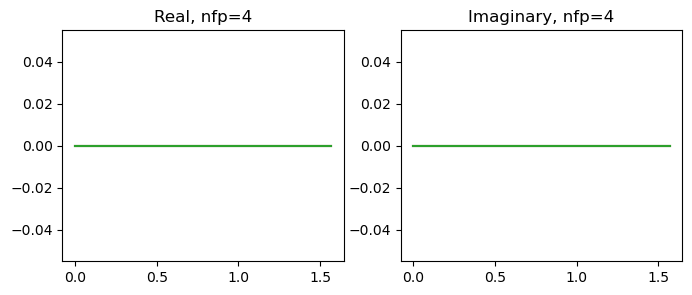

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             0.e+00         
Worst:          0.e+00          0.e+00         
Std             nan             0.e+00         
Total imaginary component
0.0

ichi
Difference


/Users/lanke/Desktop/Second year project/Code JAX/pyAQSC/examples/../python_source/chiphifunc_test_suite.py:190: RuntimeWarning: invalid value encountered in divide
  frac = np.abs((guess-ans)/ans)


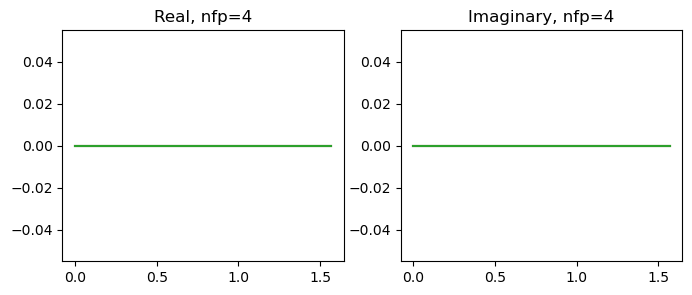

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             0.e+00         
Worst:          0.e+00          0.e+00         
Std             nan             0.e+00         
Total imaginary component
0.0



In [10]:
nfp = np.random.randint(4)+2
print('Testing dchi and ichi (even)')
rands_i = np.random.randint(1,5, size=12)
amp=0.2
test1 = amp*ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points),
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
]), nfp, trig_mode = True)

test1_int = amp*ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.zeros_like(points, dtype=np.complex128),
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
]), nfp, trig_mode = True)

dchi_test1 = amp*ChiPhiFunc(np.array([
        -2*(np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)), 
        np.zeros_like(points, dtype=np.complex128),
        2*(np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points))
]), nfp, trig_mode = True)

guess_dchi = test1.dchi()
guess_ichi = dchi_test1.antid_chi()
print('dchi')
compare_chiphifunc(guess_dchi, dchi_test1)
print('ichi')
compare_chiphifunc(guess_ichi, test1_int)

Testing dchi and ichi (odd)
dchi
Difference


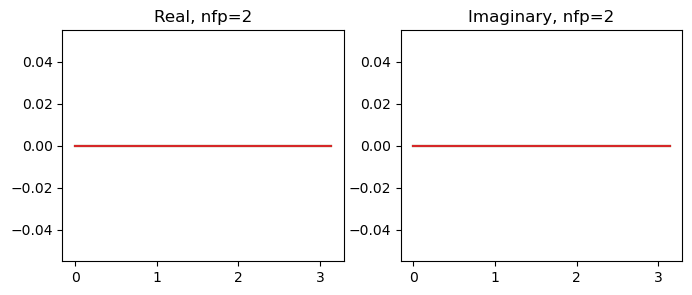

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            0.e+00          0.e+00         
Worst:          0.e+00          0.e+00         
Std             0.e+00          0.e+00         
Total imaginary component
0.0

ichi
Difference


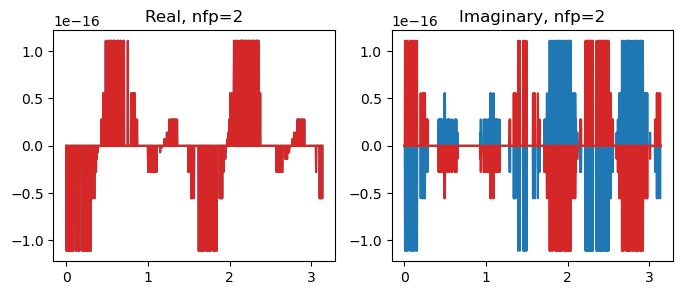

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            2.313e-17       1.583e-17      
Worst:          2.127e-16       1.570e-16      
Std             4.944e-17       3.618e-17      
Total imaginary component
0.0



In [11]:
print('Testing dchi and ichi (odd)')
nfp = np.random.randint(4)+2
rands_i = np.random.randint(1,5, size=12)

test1 = ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points), 
        np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points), 
        np.sin(rands_i[6]*points)+np.cos(rands_i[7]*points)
]), nfp, trig_mode = True)

dchi_test1 = ChiPhiFunc(np.array([
        -3*(np.sin(rands_i[6]*points)+np.cos(rands_i[7]*points)), 
        -(np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points)), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points), 
        3*(np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points))
]), nfp, trig_mode = True)

guess_dchi = test1.dchi()
guess_ichi = dchi_test1.antid_chi()
print('dchi')
compare_chiphifunc(guess_dchi, dchi_test1)
print('ichi')
compare_chiphifunc(guess_ichi, test1)

## $\partial_\phi$ and $\int d\phi$ (Works!)

In [12]:
rand_splines(3)

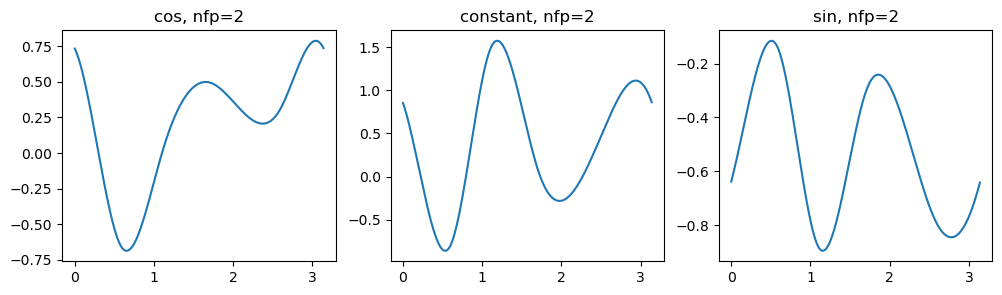

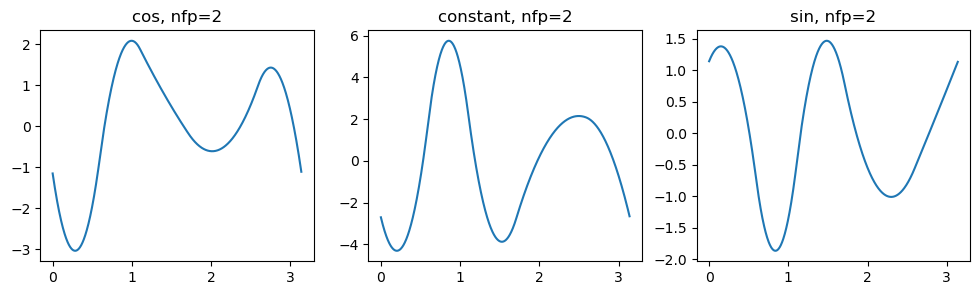

In [13]:
nfp = np.random.randint(4)+2
rand_i = np.random.randint(1,5, size=12)
test_splines = rand_splines(3)

test_diff = ChiPhiFunc_from_splines(splines=test_splines, nfp=nfp)
ans = ChiPhiFunc_from_splines(splines=test_splines, nfp=nfp, dphi_order=1)

test_diff.display_content(trig_mode=True)
ans.display_content(trig_mode=True)


Testing dphi
Current derivative modes: 1
dphi based on FFT
Difference


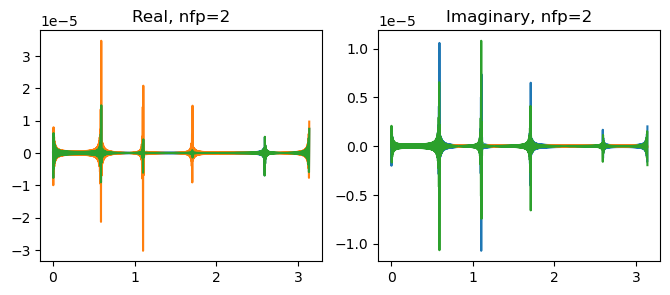

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            4.921e-07       5.567e-07      
Worst:          9.179e-05       3.469e-05      
Std             2.359e-06       1.555e-06      
Total imaginary component
0.0

dphi based on pseudo-spectral


NameError: name 'np' is not defined

In [14]:
print('Testing dphi')
print('Current derivative modes:', chiphifunc.diff_mode)

print('dphi based on FFT')
guess_fft = test_diff.dphi(mode=1)
compare_chiphifunc(guess_fft, ans)

print('dphi based on pseudo-spectral')
guess_pseudo_spectral = test_diff.dphi(mode=2)
compare_chiphifunc(guess_pseudo_spectral, ans)

In [ ]:
print('Testing integrate_phi')
amp=0.2
nfp = np.random.randint(4)+2

rands_i = np.random.randint(1,10, size=12)
test_integral = amp*ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points), 
        np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points)
]),nfp, trig_mode = True)

ans = amp*ChiPhiFunc(np.array([
        -1/rands_i[0]*np.cos(rands_i[0]*points) + 1/rands_i[1]*np.sin(rands_i[1]*points) +1/rands_i[0],
        -1/rands_i[2]*np.cos(rands_i[2]*points) + 1/rands_i[3]*np.sin(rands_i[3]*points) +1/rands_i[2],
        -1/rands_i[4]*np.cos(rands_i[4]*points) + 1/rands_i[5]*np.sin(rands_i[5]*points) +1/rands_i[4]
]), nfp, trig_mode = True)/nfp


ans_2pi = amp*ChiPhiFunc(np.array([
        [-1/rands_i[0]*np.cos(rands_i[0]*2*np.pi) + 1/rands_i[1]*np.sin(rands_i[1]*2*np.pi) +1/rands_i[0]*np.cos(0)],
        [-1/rands_i[2]*np.cos(rands_i[2]*2*np.pi) + 1/rands_i[3]*np.sin(rands_i[3]*2*np.pi) +1/rands_i[2]*np.cos(0)],
        [-1/rands_i[4]*np.cos(rands_i[4]*2*np.pi) + 1/rands_i[5]*np.sin(rands_i[5]*2*np.pi) +1/rands_i[4]*np.cos(0)]
]), nfp, trig_mode = True)/nfp

In [ ]:

# print('Testing periodic: simpson')
# guess = test_integral.integrate_phi(periodic=False, zero_avg=False, mode='simpson')
# print('Testing periodic: spline')
# print_fractional_error(test_integral.integrate_phi(periodic=True, zero_avg=None, mode = 'spline').content,ans_2pi.content)

print('Testing general')
guess_fft = test_integral.integrate_phi_fft(zero_avg=False)

# print('Simpson v. ans')
# compare_chiphifunc(guess, ans, trig_mode = False)
# print('Spline v. ans')
# compare_chiphifunc(guess_spline, ans, trig_mode = False)
print('FFT v. ans')
compare_chiphifunc(guess_fft, ans)


## `diff()` (Works!)

In [ ]:
print('Testing diff(y, is_dchi=False, 1)')
nfp = np.random.randint(4)+2
rands_i = np.random.randint(20,22, size=12)
test_diff = ChiPhiFunc(np.array([
        np.cos(rands_i[0]*points) + np.sin(rands_i[1]*points) +1/rands_i[0]*np.cos(0),
        np.cos(rands_i[2]*points) + np.sin(rands_i[3]*points) +1/rands_i[2]*np.cos(0)
]), nfp, trig_mode = True)

ans = ChiPhiFunc(np.array([
        -rands_i[0]*np.sin(rands_i[0]*points)+rands_i[1]*np.cos(rands_i[1]*points), 
        -rands_i[2]*np.sin(rands_i[2]*points)+rands_i[3]*np.cos(rands_i[3]*points)
]), nfp, trig_mode = True)*nfp

ans2 = ChiPhiFunc(np.array([
        -rands_i[0]*rands_i[0]*np.cos(rands_i[0]*points)-rands_i[1]*rands_i[1]*np.sin(rands_i[1]*points), 
        -rands_i[2]*rands_i[2]*np.cos(rands_i[2]*points)-rands_i[3]*rands_i[3]*np.sin(rands_i[3]*points)
]), nfp, trig_mode = True)*nfp*nfp

guess = diff(test_diff,False,1) # Dphi. The boolean is is_dchi
guess_fft = test_diff.dphi()
guess2 = diff(test_diff,False,2) # Dphi. The boolean is is_dchi
guess_fft2 = test_diff.dphi(2)
compare_chiphifunc(guess, ans)
compare_chiphifunc(guess2, ans2)

In [ ]:
print('Testing diff(y, is_dchi=True, 1)')
rands_i = np.random.randint(1,5, size=12)
a = np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points) 
b = np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
c = np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points) 
d = np.sin(rands_i[6]*points)+np.cos(rands_i[7]*points) 
e = np.sin(rands_i[8]*points)+np.cos(rands_i[9]*points)
test_diff = ChiPhiFunc(np.array([a,b,c,d,e]), nfp, trig_mode = True)

ans = ChiPhiFunc(np.array([-4*e,-2*d,np.zeros_like(c),2*b,4*a]), nfp, trig_mode = True)
# guess = test_diff.dchi(1)
guess = diff_backend(test_diff,True,1) # Dphi. The boolean is is_dchi
# guess = diff(test_diff,True,1) # Dphi. The boolean is is_dchi
print('dchi')
compare_chiphifunc(guess, ans)

# Testing $\phi$ ODE solvers (Works, except spline is slightly non-periodic)

## Testing SVD linear optimizer

In [3]:
n=20
a = np.random.random((n+5,n))
x = np.random.random((n))
b = a@x

# prototype for linear optimization of ||Ax-b||^2 by SVD
x_recovered = linear_least_sq_2d_svd(a, b)

print(jnp.all(jnp.isclose(x, x_recovered)))

True


## Testing the single-row solver `solve_1d()` (Works!)

In [ ]:
rand_i = np.random.randint(1,5, size=12)
test_splines = rand_splines(1)

test_p = -1#60+30*jnp.sin(points)
test_y = ChiPhiFunc_from_splines(splines=test_splines, nfp=1).content[0]
test_yp = ChiPhiFunc_from_splines(splines=test_splines, nfp=1, dphi_order=1).content[0]
test_f = test_yp+test_p*test_y

plt.plot(test_f)

In [ ]:
compare_chiphifunc(
    ChiPhiFunc_from_splines(splines=test_splines, nfp=1).dphi(), 
    ChiPhiFunc_from_splines(splines=test_splines, nfp=1, dphi_order=1))

In [ ]:
%%time
test_y_guess = solve_1d_fft(p_eff=test_p, f_eff=test_f, fft_max_freq=15)

In [ ]:
%%time
test_y_guess_asym = solve_1d_asym(p_eff=test_p, f_eff=test_f)

In [ ]:
print('Error solving with FFT with low-pass filter set to m<100')
plt.plot(test_y-test_y_guess)
plt.show()
print('Error solving with asymptotic integration factor')
plt.plot(test_y-test_y_guess_asym)
plt.show()

## Testing the batch solver `solve_integration_factor()` (Works!)

In [ ]:
# Creating 2 random ChiPhiFunc's for testing
rands1 = np.random.randint(5, size=16)

content1 = np.array([
    rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points),
    rands1[12]/10*np.sin(rands1[13]*points) + rands1[14]/10*np.cos(rands1[15]*points)
])
test1 = ChiPhiFunc(content1, 1, trig_mode = True)
# dphi + iota*dchi
dphi_test1 = ChiPhiFunc(np.array([
    rands1[1]*rands1[0]/10*np.cos(rands1[1]*points) - rands1[3]*rands1[2]/10*np.sin(rands1[3]*points),
    rands1[5]*rands1[4]/10*np.cos(rands1[5]*points) - rands1[7]*rands1[6]/10*np.sin(rands1[7]*points),
    rands1[9]*rands1[8]/10*np.cos(rands1[9]*points) - rands1[11]*rands1[10]/10*np.sin(rands1[11]*points),
    rands1[13]*rands1[12]/10*np.cos(rands1[13]*points) - rands1[15]*rands1[14]/10*np.sin(rands1[15]*points)
]), 1, trig_mode = True)

dchi_test1 = ChiPhiFunc(np.array([
    -3*(rands1[12]/10*np.sin(rands1[13]*points) + rands1[14]/10*np.cos(rands1[15]*points)),
    -(rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points)),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    3*(rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points))
]), 1, trig_mode = True)


In [ ]:

# By trying different amplitudes above, the theeshold of 
# instability seems to be 17.
start_time = time.time()
a = 1*np.array([5*np.e**(2j*points),
              np.e**(1j*points), 
              np.e**(3j*points), 
              np.e**(4j*points)], dtype = np.complex128)+0.5
b = 1
RHS = a*test1.content+b*dphi_test1.content
guess_batch_asymp = solve_integration_factor(a,b,RHS, fft_max_freq=50)
print("Batch fft time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFunc(guess_batch_asymp,1),test1)

In [ ]:


a = 5*jnp.array([5*jnp.e**(2j*points),
              jnp.e**(1j*points), 
              jnp.e**(3j*points), 
              jnp.e**(4j*points)], dtype = jnp.complex128)+0.5
b = 12
c = 2*jnp.array([7*jnp.e**(2j*points),
              jnp.e**(6j*points), 
              5*jnp.e**(3j*points), 
              jnp.e**(4j*points)], dtype = jnp.complex128)+10

RHS = a*test1.content+b*dphi_test1.content+c*test1.dchi().content
guess_batch_asymp = solve_integration_factor_chi(a,b,c,RHS, fft_max_freq=30)

compare_chiphifunc(ChiPhiFunc(guess_batch_asymp,1),test1, simple_mode=False)

## Testing the batch solver `solve_dphi_iota_dchi()` (

In [ ]:
b = 1.1
c = 1

RHS = b*dphi_test1.content+c*test1.dchi().content
guess_batch_asymp = ChiPhiFunc(solve_integration_factor_chi(0,b,c,RHS, fft_max_freq=30),1)

compare_chiphifunc(guess_batch_asymp,test1, simple_mode=False)

plt.plot((a*test1.content+b*test1.dphi().content+c*test1.dchi().content).T)
plt.plot((a*guess_batch_asymp.content+b*guess_batch_asymp.dphi().content+c*guess_batch_asymp.dchi().content).T)

# Testing $(A+B\partial_\chi)y=b$ linear system solver (Works!)

In [ ]:
# Generating coefficients
nfp = 5
coef_A = rand_ChiPhiFunc(2,nfp)
coef_B = rand_ChiPhiFunc(2,nfp)
coef_C = rand_ChiPhiFunc(3,nfp)

## Odd with center as free component

In [ ]:
test_Y = rand_ChiPhiFunc(5, nfp)
RHS = coef_A*test_Y+coef_B*test_Y.dchi()

O_matrices, O_einv, vector_free_coef, Y_nfp = \
    get_O_O_einv_from_A_B(coef_A, coef_B, 4)

guess_Y_content = (np.einsum('ijk,jk->ik',O_einv,RHS.content) + test_Y[0].content[0] * vector_free_coef)
compare_chiphifunc(ChiPhiFunc(guess_Y_content, nfp), test_Y)

## Even with $m=+1$ as free component

In [ ]:
test_Y = rand_ChiPhiFunc(6, nfp)
RHS = coef_A*test_Y+coef_B*test_Y.dchi()

O_matrices, O_einv, vector_free_coef, Y_nfp = \
    get_O_O_einv_from_A_B(coef_A, coef_B, 5)

guess_Y_content = (np.einsum('ijk,jk->ik',O_einv,RHS.content) + test_Y[1].content[0] * vector_free_coef)
compare_chiphifunc(ChiPhiFunc(guess_Y_content, Y_nfp), test_Y)

# Testing `ChiPhiEpsFunc`

In [ ]:
print('Testing append(), zero_append(), __init__(), mask() and consistency check')
orig_list = [0,1,3, jnp.array([666,667])] # legal, legal, legal, illegal
a = ChiPhiEpsFunc(orig_list,2, True) 
a = a.zero_append(2) # legal, legal
a = a.append(66) # legal
a = a.append(ChiPhiFuncSpecial(-10)) # legal
a = a.append(ChiPhiFunc(jnp.array([[1]]),2)) # legal
a = a.append(ChiPhiFunc(jnp.array([[1]]),10)) # illegal
str(a.mask(10)) == '[0, 1, 3, ChiPhiFunc(error -14), 0, 0, 66, ChiPhiFunc(error -10), ChiPhiFunc(content.shape=(1, 1), nfp=2), ChiPhiFunc(error -14), ChiPhiFunc(index out of bound)], nfp=2'

In [ ]:
print('Testing saving to and recovering from lists')
content_list, nfp = a.to_content_list()
b = ChiPhiEpsFunc.from_content_list(content_list, nfp)
print(str(a) == str(b))

In [ ]:
print('Testing jitting of formulae involving items in ChiPhiFunc and get_order()')
test_in = ChiPhiFunc(jnp.array([[1,2,3]]),1)

@jit
def test(test_in):
    return(a.append(66)[1]+a[2]+test_in, a.append(66)[99])

print(test(test_in)[0].content == jnp.array([[5.+0.j, 6.+0.j, 7.+0.j]]))
print(test(a[4])[0] == 4)
print(test(test_in)[1].nfp == -1)
@jit
def test2():
    return(ChiPhiEpsFunc.zeros_like(a))
print(test2()[a.get_order()]==0)

# Testing iteration

Configuration has 1.0 field periods.
Axis shape:


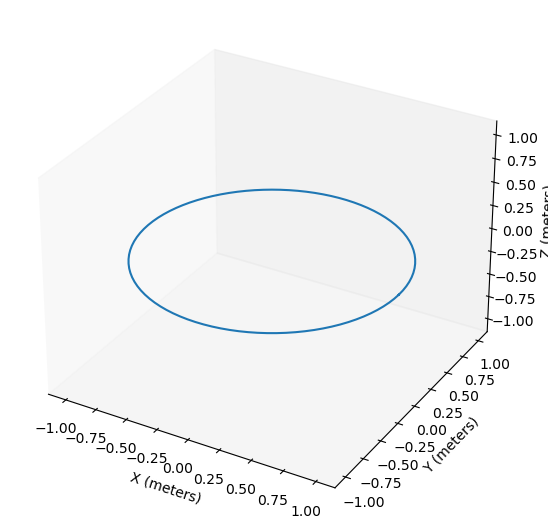

In [2]:
from equilibrium import *

debug_path = '../test_data_eduardo/'

B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'circ/', 
        R_array=[2,0,1,2,0.0001,0],
        Z_array=[1,2,0,0.001]
    )


In [3]:
%%time
equilibrium = Equilibrium.from_known(
    X_coef_cp=X_coef_cp.mask(2),
    Y_coef_cp=Y_coef_cp.mask(2),
    Z_coef_cp=Z_coef_cp.mask(2),
    B_psi_coef_cp=B_psi_coef_cp.mask(0),
    B_theta_coef_cp=B_theta_coef_cp.mask(2),
    B_denom_coef_c=B_denom_coef_c.mask(2),
    B_alpha_coef=B_alpha_coef.mask(1),
    iota_coef=iota_coef.mask(0), 
    kap_p=kap_p, 
    dl_p=dl_p, 
    tau_p=tau_p,
    p_perp_coef_cp = p_perp_coef_cp.mask(2), 
    Delta_coef_cp = Delta_coef_cp.mask(2))

CPU times: user 12.3 ms, sys: 783 µs, total: 13.1 ms
Wall time: 12.5 ms


In [4]:
%%time
B_psi_nm2 = iterate_dc_B_psi_nm2(n_eval=3,
    X_coef_cp=X_coef_cp,
    Y_coef_cp=Y_coef_cp,
    Z_coef_cp=Z_coef_cp,
    B_theta_coef_cp=B_theta_coef_cp.zero_append(),
    B_psi_coef_cp=B_psi_coef_cp,
    B_alpha_coef=B_alpha_coef,
    B_denom_coef_c=B_denom_coef_c,
    kap_p=kap_p,
    dl_p=dl_p,
    tau_p=tau_p,
    iota_coef=iota_coef
    ).antid_chi()

CPU times: user 3.72 s, sys: 130 ms, total: 3.85 s
Wall time: 3.53 s


In [5]:
print(B_psi_nm2)

ChiPhiFunc(content.shape=(2, 1000), nfp=1)


Difference


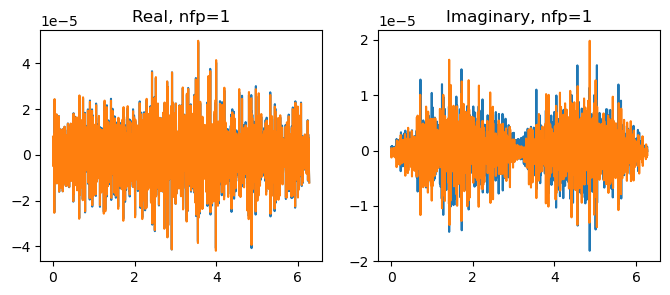

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            1.195e-05       1.103e-05      
Worst:          6.744e-05       5.065e-05      
Std             8.97e-06        7.64e-06       
Total imaginary component
0.0



In [6]:
compare_chiphifunc(B_psi_nm2,B_psi_coef_cp[1])

In [7]:
%%time
X2 = iterate_Xn_cp(2,
    X_coef_cp,
    Y_coef_cp,
    Z_coef_cp,
    B_denom_coef_c,
    B_alpha_coef,
    kap_p, dl_p, tau_p,
    iota_coef)

CPU times: user 1.17 s, sys: 51.9 ms, total: 1.22 s
Wall time: 1.1 s


Difference


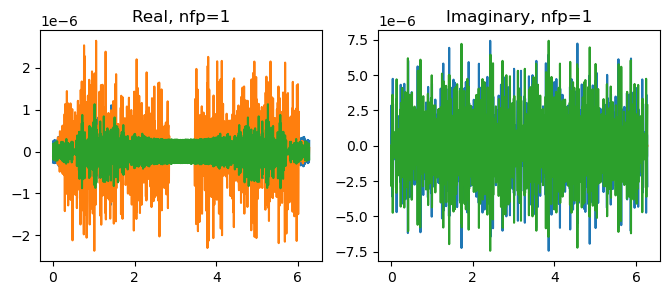

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            2.249e-05       1.590e-06      
Worst:          3.511e-04       7.438e-06      
Std             3.043e-05       1.432e-06      
Total imaginary component
0.0



In [8]:
compare_chiphifunc(X2, X_coef_cp[2])

In [9]:
%%time
Z2 = iterate_Zn_cp(
    2,
    X_coef_cp, Y_coef_cp, Z_coef_cp,
    B_theta_coef_cp, B_psi_coef_cp,
    B_alpha_coef,
    kap_p, dl_p, tau_p,
    iota_coef)

CPU times: user 813 ms, sys: 41 ms, total: 854 ms
Wall time: 674 ms


Difference


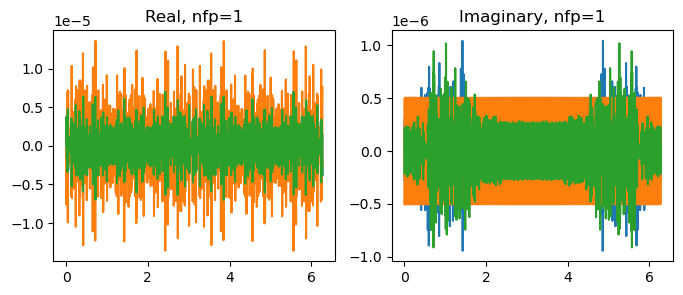

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            2.808e-05       2.546e-06      
Worst:          2.022e-02       1.362e-05      
Std             3.980e-04       2.149e-06      
Total imaginary component
0.0



In [10]:
compare_chiphifunc(Z2, Z_coef_cp[2])

In [11]:
%%time
Yn = iterate_Yn_cp_magnetic(
    2,
    X_coef_cp,
    Y_coef_cp,
    Z_coef_cp,
    B_psi_coef_cp,
    B_theta_coef_cp,
    B_alpha_coef,
    B_denom_coef_c,
    kap_p, dl_p, tau_p,
    iota_coef,
    max_freq=50, 
    Yn0=Y_coef_cp[2][0].content)

CPU times: user 1.33 s, sys: 84.6 ms, total: 1.41 s
Wall time: 1.23 s


Difference


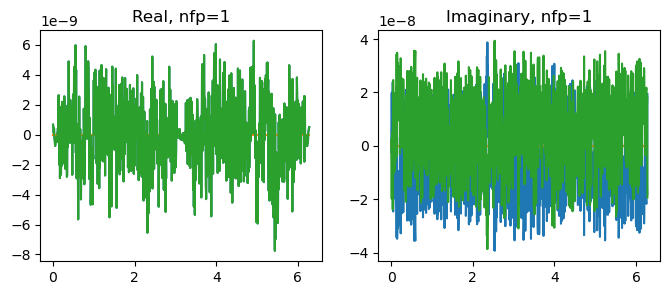

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            1.001e-08       9.325e-09      
Worst:          6.277e-08       3.933e-08      
Std             1.168e-08       9.652e-09      
Total imaginary component
0.0



In [12]:
compare_chiphifunc(Yn, Y_coef_cp[2])

In [13]:
%%time
pn = iterate_p_perp_n(2,
    B_theta_coef_cp,
    B_psi_coef_cp,
    B_alpha_coef,
    B_denom_coef_c,
    p_perp_coef_cp,
    Delta_coef_cp,
    iota_coef)

CPU times: user 883 ms, sys: 53.4 ms, total: 936 ms
Wall time: 838 ms


Difference


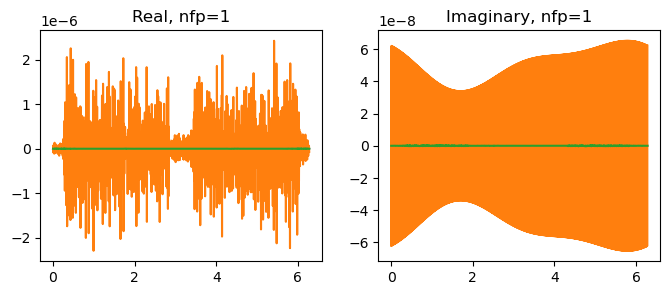

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            1.01e-05        1.890e-07      
Worst:          1.629e-02       2.431e-06      
Std             3.080e-04       3.808e-07      
Total imaginary component
0.0



In [14]:
compare_chiphifunc(pn, p_perp_coef_cp[2])

In [15]:
Delta_n = iterate_delta_n_0_offset(2,
    B_denom_coef_c,
    p_perp_coef_cp,
    Delta_coef_cp,
    iota_coef,
    max_freq=None,
    no_iota_masking = False)

n_eval 2
Delta_n_inhomog_component ChiPhiFunc(content.shape=(3, 1000), nfp=1)


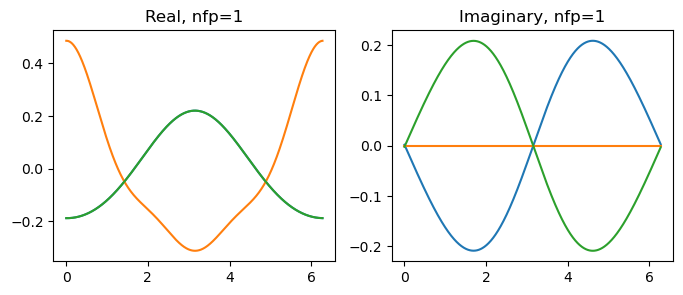

In [16]:
Delta_n.display_content()

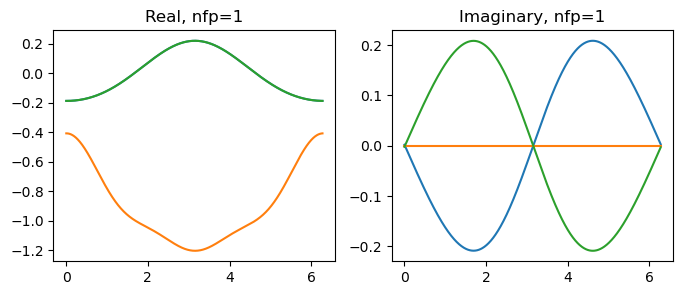

In [17]:
Delta_coef_cp[2].display_content()